We are going to use the methodology of Transfer Learning for training VGG-16 Model


# What is Transfer Learning?
It is often the case that we don't have enough data to train our model. In such situations we use pre trained model weights and optimise it as per our data and requirements.
It is widely used in Convolutional Neural Networks(CNN).
The reason being training CNNs from scratch requires too much time and also it is pretty CPU and GPU intensive task.


Here we are going to use VGG-16 model with the weights of 'Imagenet' Dataset.

First, let's mount the drive folder where data collected is stored.
 

In [ ]:
# Run this block to mount your google drive
# Follow the generated instructions

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


You will see a drive folder on the left in Files

In [ ]:
!ls "/content/drive/MyDrive/inception_model"


testing_or_cv  training


Make sure your base directory has a structure like this:-

|----training_directory

                |----garbage_image_directory
                |----non_garbage_image_directory






Import VGG model and required libraries

In [ ]:
# USING VGG-MODEL

import keras,os
import numpy as np
import tensorflow as tf
import cv2
import matplotlib.pyplot as plt

from tensorflow.python.util import deprecation
from tensorflow.keras import backend
from tensorflow.keras.applications.resnet50 import preprocess_input
# deprecation._PRINT_DEPRECATION_WARNINGS = False

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPool2D, Flatten
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.applications.vgg16 import VGG16
from keras.preprocessing import image
from tensorflow.keras.models import load_model
print("Imports done.")

Imports done.


You can see the summary about the diiferent layers in the VGG16 model.

In [ ]:
#load model
model = VGG16()
#summarize the model
model.summary()


553467904/553467096 [==============================] - 4s 0us/step
Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
____________________________________________________________

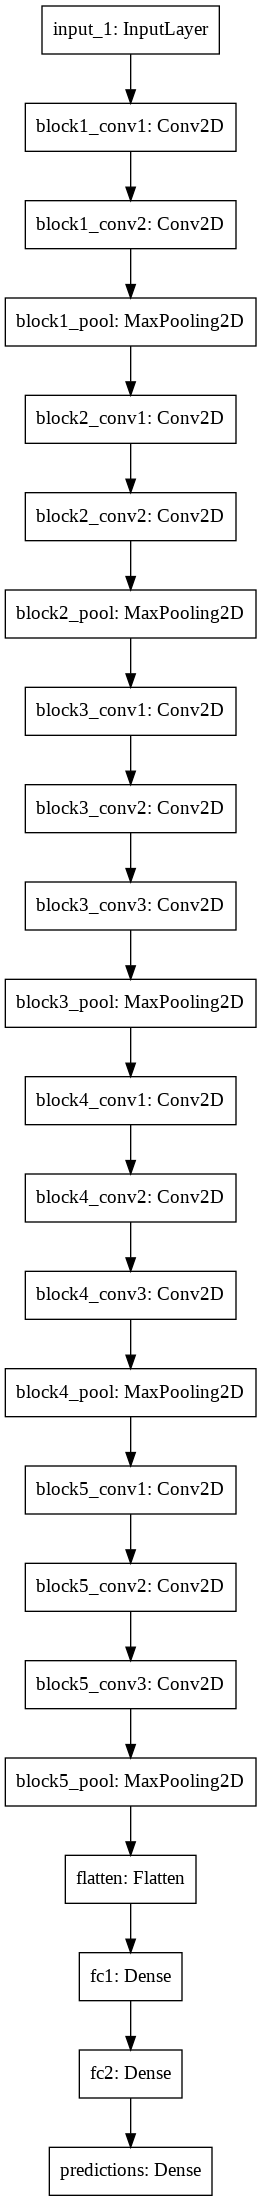

In [ ]:
from keras.utils import  plot_model
plot_model(model)

First Lets try to classify our image based on the VGG16 model using imagenet weights.

In [ ]:
# example of using a pre-trained model as a classifier
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from keras.applications.vgg16 import preprocess_input
from keras.applications.vgg16 import decode_predictions

# load an image from file
image = load_img('/content/drive/MyDrive/inception_model/training/garbage/1.jpg', target_size=(224, 224))
# convert the image pixels to a numpy array
image = img_to_array(image)
# reshape data for the model
image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
# prepare the image for the VGG model
image = preprocess_input(image)
# load the model
model = VGG16( weights='imagenet')
# predict the probability across all output classes
yhat = model.predict(image)
# convert the probabilities to class labels
label = decode_predictions(yhat)
# retrieve the most likely result, e.g. highest probability
label = label[0][0]
# print the classification
print('%s (%.2f%%)' % (label[1], label[2]*100))

40960/35363 [==================================] - 0s 0us/step
viaduct (16.16%)


You can see what the VGG16 model predicted.
Now coming to the point, we want to do binary classification to tell whether there is garbage in our picture or not. We also need to train our model on our image data. For that we usually augment our data into a data frame using pandas llibrary but since our base directory already contains two classes, we do not need to construct a dataframe.

You can consider a dataframe as a tabular representation of data with rows and columns as you have probably seen in Excel.


In [ ]:
HEIGHT = 64
WIDTH = 64
base_model = VGG16(weights='imagenet', 
                      include_top=False, 
                      input_shape=(HEIGHT, WIDTH, 3))


58892288/58889256 [==============================] - 0s 0us/step


Notice that we have used include_top=False. This setting is important, as it means that we won’t be keeping the Fully-Connected (FC) layers at the end of the model. This is exactly what we want since we’re going to train our own brand new FC layers for transfer learning.

Also note that we are using the weights which were trained on imagenet dataset.


ImageDataGenerator is used to artificially expand the size of the training image data.

In [ ]:
from keras.preprocessing.image import ImageDataGenerator

TRAIN_DIR = "/content/drive/MyDrive/inception_model/training"
HEIGHT = 64
WIDTH = 64
BATCH_SIZE = 2

train_datagen =  ImageDataGenerator(rescale=1./255.,
                                    validation_split=0.2,
                                    rotation_range=30,
                                    width_shift_range=0.2,
                                    height_shift_range=0.2,
                                    shear_range=0.15,
                                    horizontal_flip=True,
                                    fill_mode="nearest")


train_generator = train_datagen.flow_from_directory(TRAIN_DIR, 
                                                    target_size=(HEIGHT, WIDTH), 
                                                    batch_size=BATCH_SIZE,
                                                    shuffle=True,
                                                    class_mode="categorical")

Found 20 images belonging to 2 classes.


In [ ]:
from keras.layers import Dense, Activation, Flatten, Dropout
from keras.models import Sequential, Model

def build_finetune_model(base_model, dropout, fc_layers, num_classes):
    for layer in base_model.layers:
        layer.trainable = False

    x = base_model.output
    x = Flatten()(x)
    for fc in fc_layers:
        # New FC layer, random init
        x = Dense(fc, activation='relu')(x) 
        x = Dropout(dropout)(x)

    # New softmax layer
    predictions = Dense(num_classes, activation='softmax')(x) 
    
    finetune_model = Model(inputs=base_model.input, outputs=predictions)

    return finetune_model

class_list = ["Garbage", "Not_Garbage"]

FC_LAYERS = [1024, 1024]
dropout = 0.5

finetune_model = build_finetune_model(base_model, 
                                      dropout=dropout, 
                                      fc_layers=FC_LAYERS, 
                                      num_classes=len(class_list))


Epoch 1/10
1/1 [==============================] - 2s 2s/step - loss: 0.6363 - accuracy: 1.0000

Epoch 00001: saving model to ./checkpoints/_model_weights.h5
Epoch 2/10
1/1 [==============================] - 1s 513ms/step - loss: 1.1332 - accuracy: 0.0000e+00

Epoch 00002: saving model to ./checkpoints/_model_weights.h5
Epoch 3/10
1/1 [==============================] - 1s 506ms/step - loss: 0.8071 - accuracy: 0.5000

Epoch 00003: saving model to ./checkpoints/_model_weights.h5
Epoch 4/10
1/1 [==============================] - 1s 514ms/step - loss: 0.6870 - accuracy: 0.5000

Epoch 00004: saving model to ./checkpoints/_model_weights.h5
Epoch 5/10
1/1 [==============================] - 1s 504ms/step - loss: 0.7656 - accuracy: 0.0000e+00

Epoch 00005: saving model to ./checkpoints/_model_weights.h5
Epoch 6/10
1/1 [==============================] - 1s 517ms/step - loss: 1.0768 - accuracy: 0.5000

Epoch 00006: saving model to ./checkpoints/_model_weights.h5
Epoch 7/10
1/1 [===================

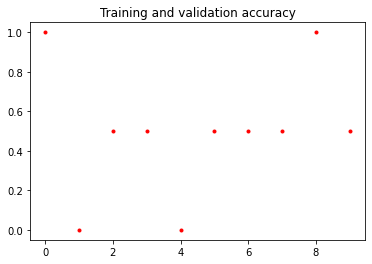

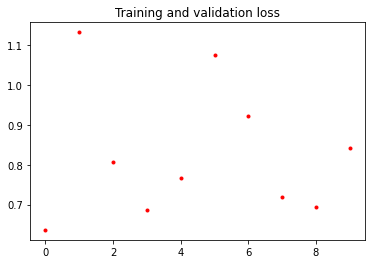

<Figure size 432x288 with 0 Axes>

In [ ]:
from keras.optimizers import SGD, Adam
from keras.callbacks import ModelCheckpoint
import matplotlib.pyplot as plt

NUM_EPOCHS = 10
BATCH_SIZE = 8
num_train_images = 10

adam = Adam(lr=0.00001)
finetune_model.compile(adam, loss='binary_crossentropy', metrics=['accuracy'])

filepath="./checkpoints/" + "_model_weights.h5"
checkpoint = ModelCheckpoint(filepath, monitor=["accuracy"], verbose=1, mode='max')
callbacks_list = [checkpoint]

history = finetune_model.fit(train_generator, epochs=NUM_EPOCHS,
                                       workers=8, 
                                       steps_per_epoch=num_train_images // BATCH_SIZE, 
                                        callbacks=callbacks_list,
                                        shuffle=True)



# Plot the training and validation loss + accuracy
def plot_training(history):
    acc = history.history['accuracy']
   # val_acc = history.history['val_acc']
    loss = history.history['loss']
   # val_loss = history.history['val_loss']
    epochs = range(len(acc))

    plt.plot(epochs, acc, 'r.')
   # plt.plot(epochs, val_acc, 'r')
    plt.title('Training and validation accuracy')

    plt.figure()
    plt.plot(epochs, loss, 'r.')
    plt.title('Training and validation loss')
    plt.show()

    plt.savefig('acc_vs_epochs.png')

    
plot_training(history)

In [ ]:
finetune_model.save('/content/vgg16binary.h5')

In [ ]:
from tensorflow.keras.models import load_model

Model = load_model('/content/vgg16binary.h5')
Model.compile(adam, loss='binary_crossentropy', metrics=['accuracy'])

Now let's use our trained model to classify garbage and non_garbage images.


In [ ]:

# load an image from file
image = load_img('/content/drive/MyDrive/inception_model/testing_or_cv/garbage/2.jpg', target_size=(64, 64))
# convert the image pixels to a numpy array
image = img_to_array(image)
# reshape data for the model
image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
# prepare the image for the VGG model
image = preprocess_input(image)
# load the model
Model.predict(image)
# predict the probability across all output classes
yhat = Model.predict(image)
np.set_printoptions(precision=5,suppress=True)

for m in range(0,len(class_list)) :
  print(str(class_list[m])+" probability ->"+str(yhat[0][m]*100))

Garbage probability ->98.6884355545044
Not_Garbage probability ->1.311566587537527
